Lo que hemos visto en la sección anterior, es una forma más manual de hacer la normalización.

A continuación, condensaremos el conocimiento anterior.


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch.manual_seed(3)

transform = transforms.ToTensor()

train_full = datasets.CIFAR10("./data", train=True, download=True, transform=transform)


#Obtenemos el dataset train completo
loader_train = DataLoader(train_full, batch_size=len(train_full), shuffle=False)                       
#Obtenemos un batch de datos
imgs, _ = next(iter(loader_train))             
imgs = imgs.to(torch.float64)
print(imgs.shape) # [50000,3,32,32]

CIFAR10_MEAN = imgs.mean(dim=(0,2,3))
CIFAR10_STD  = imgs.std(dim=(0,2,3))
print(CIFAR10_MEAN, CIFAR10_STD)


cuda
torch.Size([50000, 3, 32, 32])
tensor([0.4914, 0.4822, 0.4465], dtype=torch.float64) tensor([0.2470, 0.2435, 0.2616], dtype=torch.float64)


In [3]:

#CIFAR10_MEAN = torch.tensor([0.4914, 0.4822, 0.4465])
#CIFAR10_STD  = torch.tensor([0.2470, 0.2435, 0.2616])

#Creamos el transform para normalización

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN.tolist(), CIFAR10_STD.tolist())
])

# Re-creamos los datasets con el nuevo transform
train_full = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)


#Comprobamos que los datos estan normalizados
check_loader_train_full = DataLoader(train_full, batch_size=len(train_full), shuffle=False) #Dataset completo para calcular la media y la desviación estándar de los datos ya normalizados
x, _ = next(iter(check_loader_train_full))
mean_check = x.mean(dim=(0, 2, 3))
std_check  = x.std(dim=(0, 2, 3))
print("Mean Appx: 0):", mean_check)
print("Std Appx: 1):", std_check)
assert mean_check.abs().max() < 0.05
assert (std_check - 1).abs().max() < 0.05



#Dividimos el dataset en train y validation
train_set, val_set = torch.utils.data.random_split(generator=torch.Generator().manual_seed(3), dataset=train_full, lengths=[40000, 10000])
#Comprobamos que el dataset se ha dividido correctamente
print(len(train_set), len(val_set))

#Nuestros loaders para entrenar, validar y testear, ya normalizados.
loader_train = DataLoader(train_set, batch_size=128, shuffle=True) #Barajamos porque es train y mejora la generalización
loader_val = DataLoader(val_set, batch_size=256, shuffle=False)
loader_test = DataLoader(test_set, batch_size=256, shuffle=False)








Mean Appx: 0): tensor([ 6.3542e-08, -1.9292e-08, -4.8446e-08])
Std Appx: 1): tensor([1.0000, 1.0000, 1.0000])
40000 10000


Vamos ahora a coger el primer batch

In [4]:
images, labels = next(iter(loader_train))
print(images.shape, labels.shape)

torch.Size([128, 3, 32, 32]) torch.Size([128])


# Declaración de arquitectura

In [5]:

import torch.nn as nn

def get_flatten_size(model_features, input_shape=(1, 3, 32, 32)):
    with torch.no_grad():
        x = torch.zeros(input_shape)
        out = model_features(x)
        return out.view(out.size(0), -1).size(1)

class CIFAR10CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.features = nn.Sequential(

            #Primera capa de convolucion, entra una imagen de 3 canales y sale una imagen de 32 features
            #El kernel es de 3x3 y el padding es 1 (same padding)
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), #Aplicamos la funcion de activacion ReLU
            nn.MaxPool2d(kernel_size=2, stride=2), #Aplicamos pooling max para reducir la dimensionalidad de la imagen

            #Segunda capa de convolucion, entra una imagen de 16 features y sale una imagen de 32 features
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), #Aplicamos la funcion de activacion ReLU
            nn.MaxPool2d(kernel_size=2, stride=2), #Aplicamos pooling max para reducir la dimensionalidad de la imagen

            #Tercera capa de convolucion, entra una imagen de 32 features y sale una imagen de 64 features
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), #Aplicamos la funcion de activacion ReLU
            nn.MaxPool2d(kernel_size=2, stride=2), #Aplicamos pooling max para reducir la dimensionalidad de la imagen

             nn.Dropout(p=0.3), #Aplicamos dropout para evitar el overfitting
        )

        n_flat = get_flatten_size(self.features)

        

        #Añadimos una capa lineal para clasificar
        self.classifier = nn.Sequential(
            nn.Flatten(), #Aplanamos la imagen para que sea un vector
          
            
            nn.Linear(in_features=n_flat, out_features=500), #Una capa lineal con n_flat entradas y 500 salidas
            nn.ReLU(), #Aplicamos la funcion de activacion ReLU
            nn.Dropout(p=0.4), #Aplicamos dropout para evitar el overfitting
            
            nn.Linear(in_features=500, out_features=10), #Una capa lineal con 500 entradas y 10 salidas
            # No aplicamos softmax, ya que la funcion de perdida que usamos (CrossEntropyLoss) lo aplica por defecto
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x





# Instancia
model = CIFAR10CNN()
print(model)

x = torch.randn(4, 3, 32, 32)
logits = model(x)
print(logits.shape)



CIFAR10CNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=500, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=500, out_features=10, bias=True)
  )
)
torch.Size([4, 10])


In [6]:
from torchsummary import summary

summary(model.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
              ReLU-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
          Dropout-10             [-1, 64, 4, 4]               0
          Flatten-11                 [-1, 1024]               0
           Linear-12                  [-1, 500]         512,500
             ReLU-13                  [-1, 500]               0
          Dropout-14                  [

### Vamos a declarar el bucle de entramiento

Vamos a recordar los parametros tipicos de SDG

| Parámetro  | Rol                                                      | Valor típico |
| ---------- | -------------------------------------------------------- | ------------ |
| `lr`       | tamaño del paso (cuánto cambian los pesos por gradiente) | 0.01–0.1     |
| `momentum` | cuánto “recuerda” del gradiente anterior                 | 0.8–0.95     |


In [7]:
EPOCHS = 30  # número de pasadas por el dataset
lr = 0.01
momentum = 0.9
#Definimos la funcion de perdida y el optimizador
criterion = nn.CrossEntropyLoss()

#lr es la tasa de aprendizaje, momentum es el factor de inercia, es decir, cuanto se mueve el optimizador en la direccion del gradiente y 
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)


model.to(device)  # mueve el modelo a GPU
model.train()     # pone el modelo en modo entrenamiento (activa dropout, etc.)



CIFAR10CNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=500, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=500, out_features=10, bias=True)
  )
)

In [8]:
for epoch in range(1, EPOCHS+1):
    total, correct = 0, 0
    running_loss = 0.0
    print(f"[inicio] epoch {epoch}")


[inicio] epoch 1
[inicio] epoch 2
[inicio] epoch 3
[inicio] epoch 4
[inicio] epoch 5
[inicio] epoch 6
[inicio] epoch 7
[inicio] epoch 8
[inicio] epoch 9
[inicio] epoch 10
[inicio] epoch 11
[inicio] epoch 12
[inicio] epoch 13
[inicio] epoch 14
[inicio] epoch 15
[inicio] epoch 16
[inicio] epoch 17
[inicio] epoch 18
[inicio] epoch 19
[inicio] epoch 20
[inicio] epoch 21
[inicio] epoch 22
[inicio] epoch 23
[inicio] epoch 24
[inicio] epoch 25
[inicio] epoch 26
[inicio] epoch 27
[inicio] epoch 28
[inicio] epoch 29
[inicio] epoch 30


In [9]:
def evaluate(model, loader, device, criterion):
    model.eval()
    total, correct, total_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            total_loss += loss.item() * images.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total

#Vamos a guardar los resultados de las epocas para poder hacer graficas
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []


for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in loader_train:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    test_loss, test_acc = evaluate(model, loader_test, device, criterion)

    #Vamos a guardar los resultados de las epocas para poder hacer graficas
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(
        f"Época {epoch}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
        f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}"
    )


Época 1/30 | Train Loss: 1.9554 | Train Acc: 0.2781 | Test Loss: 1.5438 | Test Acc: 0.4320
Época 2/30 | Train Loss: 1.4875 | Train Acc: 0.4544 | Test Loss: 1.3499 | Test Acc: 0.5201
Época 3/30 | Train Loss: 1.2970 | Train Acc: 0.5325 | Test Loss: 1.1595 | Test Acc: 0.5873
Época 4/30 | Train Loss: 1.1724 | Train Acc: 0.5818 | Test Loss: 1.0332 | Test Acc: 0.6369
Época 5/30 | Train Loss: 1.0760 | Train Acc: 0.6173 | Test Loss: 0.9538 | Test Acc: 0.6702
Época 6/30 | Train Loss: 0.9891 | Train Acc: 0.6521 | Test Loss: 0.9324 | Test Acc: 0.6768
Época 7/30 | Train Loss: 0.9354 | Train Acc: 0.6698 | Test Loss: 0.8822 | Test Acc: 0.6910
Época 8/30 | Train Loss: 0.8872 | Train Acc: 0.6872 | Test Loss: 0.8295 | Test Acc: 0.7128
Época 9/30 | Train Loss: 0.8428 | Train Acc: 0.7047 | Test Loss: 0.7981 | Test Acc: 0.7250
Época 10/30 | Train Loss: 0.7965 | Train Acc: 0.7192 | Test Loss: 0.7823 | Test Acc: 0.7297
Época 11/30 | Train Loss: 0.7630 | Train Acc: 0.7340 | Test Loss: 0.7713 | Test Acc: 0.73

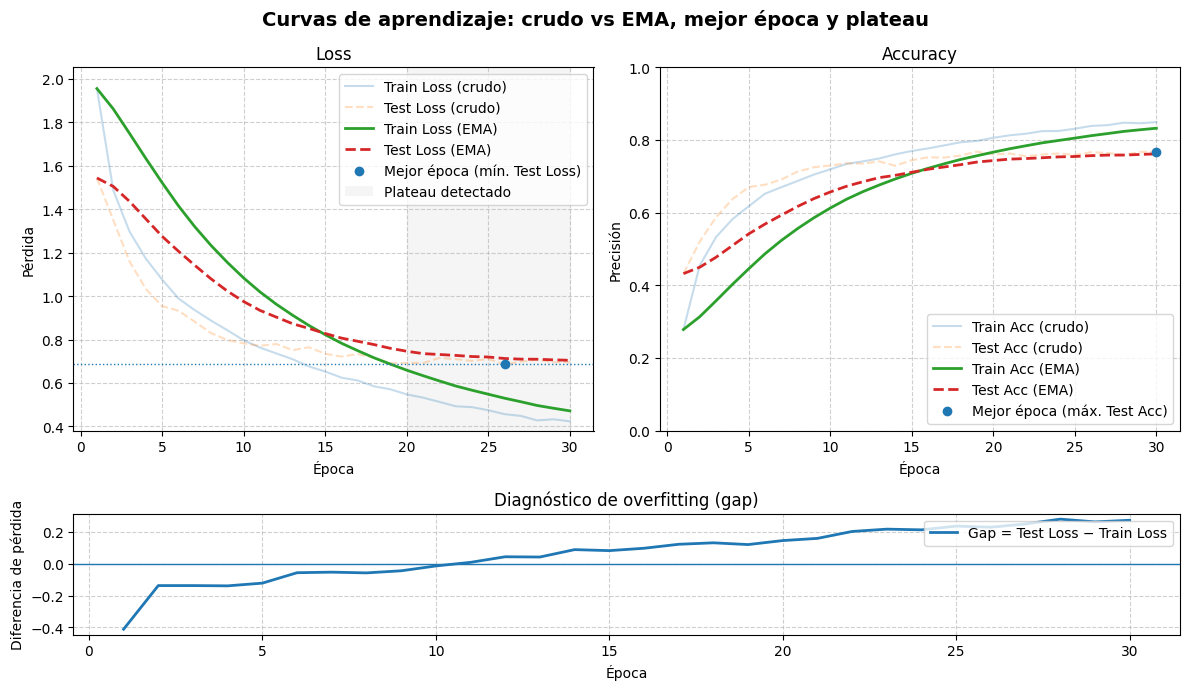

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch

def ema(x, alpha=0.2):
    y = np.array(x, dtype=float)
    for i in range(1, len(y)):
        y[i] = alpha*y[i] + (1-alpha)*y[i-1]
    return y

def plateau_start(vals, patience=5, min_delta=1e-3):
    best = float('inf'); count = 0
    for i, v in enumerate(vals):
        if v < best - min_delta:
            best = v; count = 0
        else:
            count += 1
            if count == patience:
                return i - patience + 1
    return None

epochs = np.arange(1, len(train_losses)+1)
trL, teL = np.array(train_losses), np.array(test_losses)
trA, teA = np.array(train_accuracies), np.array(test_accuracies)

trL_s, teL_s = ema(trL, 0.2), ema(teL, 0.2)
trA_s, teA_s = ema(trA, 0.2), ema(teA, 0.2)

best_loss_idx = int(np.argmin(teL))
best_acc_idx  = int(np.argmax(teA))
gap = teL - trL
plat_idx = plateau_start(teL, patience=5, min_delta=1e-3)

fig = plt.figure(figsize=(12,7))
gs = GridSpec(2, 2, height_ratios=[3,1], figure=fig)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(epochs, trL, alpha=0.25, label='Train Loss (crudo)')
ax1.plot(epochs, teL, alpha=0.25, linestyle='--', label='Test Loss (crudo)')
ax1.plot(epochs, trL_s, linewidth=2, label='Train Loss (EMA)')
ax1.plot(epochs, teL_s, linewidth=2, linestyle='--', label='Test Loss (EMA)')
ax1.scatter(epochs[best_loss_idx], teL[best_loss_idx], zorder=3, label='Mejor época (mín. Test Loss)')
ax1.axhline(teL[best_loss_idx], linestyle=':', linewidth=1)
if plat_idx is not None:
    ax1.axvspan(epochs[plat_idx], epochs[-1], alpha=0.08, color='gray')
ymin = min(trL.min(), teL.min())*0.9
ymax = max(trL.max(), teL.max())*1.05
ax1.set_ylim(ymin, ymax)
ax1.set_xlabel('Época'); ax1.set_ylabel('Pérdida'); ax1.set_title('Loss')
handles, labels = ax1.get_legend_handles_labels()
if plat_idx is not None:
    handles += [Patch(facecolor='gray', alpha=0.08, label='Plateau detectado')]
    labels += ['Plateau detectado']
ax1.grid(True, linestyle='--', alpha=0.6); ax1.legend(handles, labels, loc='upper right')

ax2 = fig.add_subplot(gs[0,1])
ax2.plot(epochs, trA, alpha=0.25, label='Train Acc (crudo)')
ax2.plot(epochs, teA, alpha=0.25, linestyle='--', label='Test Acc (crudo)')
ax2.plot(epochs, trA_s, linewidth=2, label='Train Acc (EMA)')
ax2.plot(epochs, teA_s, linewidth=2, linestyle='--', label='Test Acc (EMA)')
ax2.scatter(epochs[best_acc_idx], teA[best_acc_idx], zorder=3, label='Mejor época (máx. Test Acc)')
ax2.set_ylim(0, 1.0)
ax2.set_xlabel('Época'); ax2.set_ylabel('Precisión'); ax2.set_title('Accuracy')
ax2.grid(True, linestyle='--', alpha=0.6); ax2.legend(loc='lower right')

ax3 = fig.add_subplot(gs[1, :])
ax3.plot(epochs, gap, linewidth=2, label='Gap = Test Loss − Train Loss')
ax3.axhline(0.0, linewidth=1)
ax3.set_xlabel('Época'); ax3.set_ylabel('Diferencia de pérdida'); ax3.set_title('Diagnóstico de overfitting (gap)')
ax3.grid(True, linestyle='--', alpha=0.6); ax3.legend(loc='upper right')

plt.suptitle('Curvas de aprendizaje: crudo vs EMA, mejor época y plateau', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


Como vemos en la gráfica, con 30 epocas, lr 0.01 y mnt 0,9 comenzamos a ver overfitting además de plateau.

### ¿Que es plateu?

El plateau es la fase plana de la curva de aprendizaje, cuando:

- La pérdida ya no baja mucho.

- La precisión mejora solo unas décimas o incluso se estanca.

Aqui se ve a partir de la época 17–20.

Ahí el modelo ya está cerca de su mejor punto, pero el lr=0.01 sigue siendo demasiado alto para mejorar más.
Por eso ves las pequeñas oscilaciones finales: el optimizador “rebota” alrededor del mínimo.

En la siguiente sección veremos como mejorar esto, usando un scheduler y puede que data augmentation.

### ¿Que es un scheduler?

Un scheduler (programador de tasa de aprendizaje) es un mecanismo que cambia el learning rate (lr) durante el entrenamiento.

Cuando usas SGD con un lr fijo (por ejemplo 0.01), cada actualización de los pesos se hace con el mismo tamaño de paso.
Eso funciona bien al principio, cuando el modelo aún está lejos del mínimo.
Pero al acercarse al óptimo, esos pasos fijos se vuelven demasiado grandes y hacen que el modelo oscile alrededor del mejor punto en lugar de afinarlo.

El scheduler reduce automáticamente el lr a medida que pasan las épocas o cuando detecta que el modelo ya no mejora.
Así:

Al principio: pasos grandes → aprende rápido.

Luego: pasos pequeños → ajusta fino sin “rebotar”.

